In [1]:
#Connect Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
! python --version 


Python 3.6.9


In [3]:

%cd "/content/gdrive/My Drive/ProjetNLPQuora/"
!ls


/content/gdrive/My Drive/ProjetNLPQuora
bert-master  embq1.csv		  model_w2c_6.h5  train.csv
cache	     glove.840B.300d.txt  test.csv


In [0]:
import pandas as pd
df_train = pd.read_csv("train.csv")

# DATA PREPARATION 

In [5]:
from __future__ import print_function

import numpy as np
from os.path import expanduser, exists

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [0]:
GLOVE = 'glove.840B.300d.txt'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

In [0]:
# CLEANING FOR TOKENZING
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)

df_train["question1"] = df_train["question1"].astype("str")
df_train["question2"] = df_train["question2"].astype('str')

q1 = df_train['question1'].tolist()
q2 = df_train['question2'].tolist()

In [8]:
# TOKENIZATION AND CREATING DICTIONNARY
questions = q1 + q2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequences = tokenizer.texts_to_sequences(q1)
question2_word_sequences = tokenizer.texts_to_sequences(q2)
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 95595


In [9]:

print("Processing", GLOVE)

embeddings_index = {}
with open(GLOVE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Processing glove.840B.300d.txt
Word embeddings: 2196016


In [10]:
# CREATING WORD EMBEDDING MATRIX 
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 29275


In [11]:
# PADDING SEQ TO HAVE VECTORS OF SAME DIMENTIONS
q1_data = pad_sequences(question1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(df_train['is_duplicate'], dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (404287, 25)
Shape of question2 data tensor: (404287, 25)
Shape of label tensor: (404287,)


# CREATING NETWORK

In [0]:
%matplotlib inline
from __future__ import print_function
import numpy as np

import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

In [0]:
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 5
DROP_RATIO = 0.2
BATCH_SIZE = 512

In [0]:
# CREATING ARRAYS 
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [0]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

#Defining siamese embedding layers

q1 = Embedding(nb_words + 1,WORD_EMBEDDING_DIM,weights=[word_embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)(question1)
q1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1,WORD_EMBEDDING_DIM,weights=[word_embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)(question2)
q2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2)

#Attention layer + Dense

attention1 = dot([q1,q2], [1,1])
attention1 = Flatten()(attention1)
attention1 = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention1)
attention1 = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention1)

# FC Network

x = add([q1,attention1])
x = Flatten()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(DROP_RATIO)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(DROP_RATIO)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(DROP_RATIO)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(DROP_RATIO)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(DROP_RATIO)(x)
x = BatchNormalization()(x)

out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[question1,question2], outputs=out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      28678800    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 300)      28678800    input_2[0][0]                    
____________________________________________________________________________________________

In [17]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
with tf.device('/device:GPU:0'):
  print("Starting training at", datetime.datetime.now())
  t0 = time.time()
  history = model.fit([Q1_train, Q2_train],
                      y_train,
                      epochs=NB_EPOCHS,
                      validation_split=VALIDATION_SPLIT,
                      verbose=1,
                      batch_size=BATCH_SIZE)
  t1 = time.time()
  print("Training ended at", datetime.datetime.now())
  print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-05-14 10:43:40.312545
Train on 327472 samples, validate on 36386 samples
Epoch 1/5
327472/327472 [==============================] - 165s 505us/step - loss: 0.5475 - accuracy: 0.7173 - val_loss: 0.4830 - val_accuracy: 0.7583
Epoch 2/5
327472/327472 [==============================] - 163s 497us/step - loss: 0.4451 - accuracy: 0.7814 - val_loss: 0.4420 - val_accuracy: 0.7815
Epoch 3/5
327472/327472 [==============================] - 164s 501us/step - loss: 0.3978 - accuracy: 0.8086 - val_loss: 0.4173 - val_accuracy: 0.7995
Epoch 4/5
327472/327472 [==============================] - 164s 501us/step - loss: 0.3575 - accuracy: 0.8324 - val_loss: 0.4201 - val_accuracy: 0.8029
Epoch 5/5
327472/327472 [==============================] - 163s 496us/step - loss: 0.3183 - accuracy: 0.8543 - val_loss: 0.4037 - val_accuracy: 0.8151
Training ended at 2020-05-14 10:57:23.468882
Minutes elapsed: 13.719269


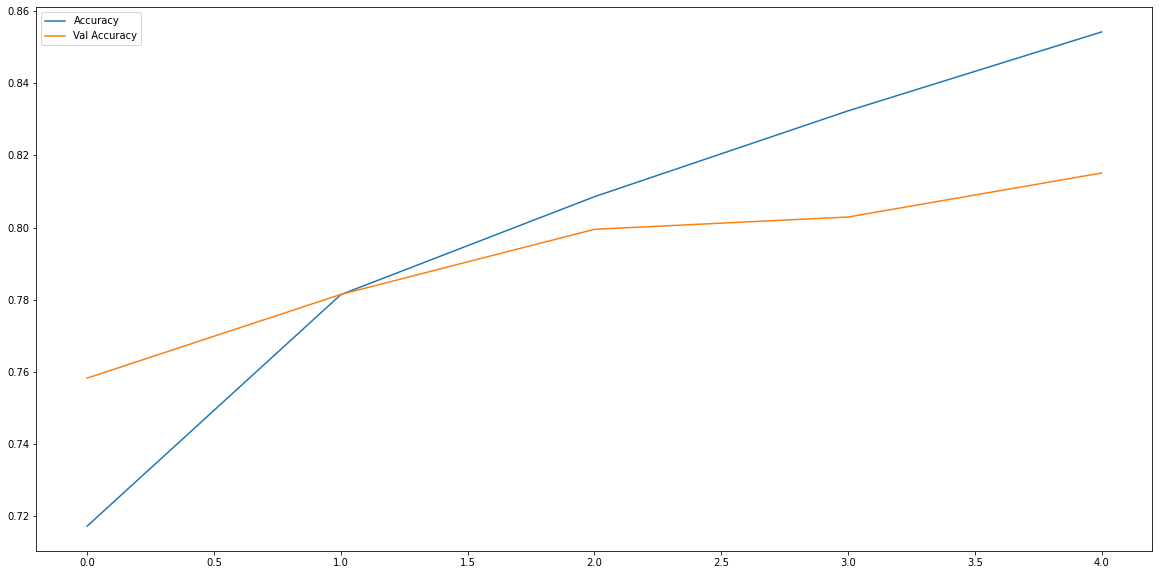

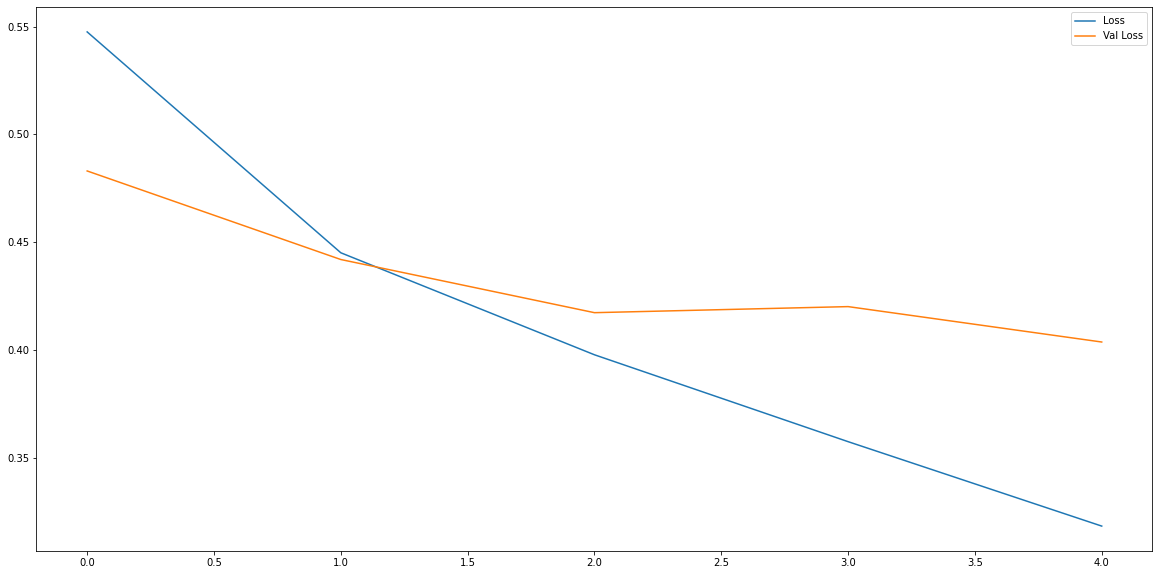

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'],  label = 'Val Accuracy')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'],  label = 'Val Loss')
plt.legend()

In [20]:
model.evaluate([Q1_test, Q2_test],y_test)

40429/40429 [==============================] - 33s 821us/step


[0.3988610464323873, 0.8172599077224731]